In [60]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [61]:
file_path = r"C:\Users\adity\Downloads\arxiv_data.csv"

arxiv_data = pd.read_csv(file_path)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [62]:
arxiv_data.shape

(51774, 3)

In [63]:
arxiv_data.duplicated().sum()

12783

In [65]:
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()

In [66]:
print(labels)
print(len(labels))

['cs.CV' 'cs.LG' 'cs.AI' ... 'I.2.6; I.5.1; G.3'
 '92E10, 46M20, 94A08, 68U10, 44A12, 55R35' '92E10']
1099


In [68]:
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]

In [69]:
arxiv_data.shape

(38972, 3)

In [72]:
print(sum(arxiv_data['terms'].value_counts() == 1))
print(arxiv_data['terms'].nunique())

2321
3157


In [75]:
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [102]:
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI'])], dtype=object)

In [103]:
train_df, test_df = train_test_split(arxiv_data_filtered, test_size = 0.1, stratify=arxiv_data_filtered['terms'].values,)

In [104]:
train_df.shape

(32985, 3)

In [105]:
test_df.shape

(3666, 3)

In [106]:
val_df = test_df.sample(frac = 0.5)
test_df.drop(val_df.index, inplace=True)

In [107]:
val_df.shape, test_df.shape

((1833, 3), (1833, 3))

In [108]:
train_df.shape

(32985, 3)

In [109]:
terms = tf.ragged.constant(train_df['terms'])
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

In [110]:
train_df['terms']

19760    [cs.LG, cs.NE, physics.data-an, stat.ML]
30876                [cs.CV, cs.AI, cs.LG, cs.MM]
41677                              [cs.CV, cs.LG]
32109                     [cs.LG, cs.IT, math.IT]
13300                            [cs.LG, stat.ML]
                           ...                   
23679                                     [cs.CV]
22463                                     [cs.LG]
2449                               [cs.LG, cs.AI]
43228                                     [cs.CV]
34217                     [cs.LG, cs.AI, stat.ML]
Name: terms, Length: 32985, dtype: object

In [111]:
sample_label = train_df['terms'].iloc[3]
print(sample_label)
label_binarized = lookup([sample_label])
print(label_binarized)

['cs.LG', 'cs.IT', 'math.IT']
tf.Tensor(
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]], shape=(1, 153), dtype=int64)


In [112]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["summaries"].values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    
    return dataset.batch(batch_size)

train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [118]:
def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[...,0]
    return np.take(vocab, hot_indices)

text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(invert_multi_hot(label))

Abstract: b'Scene graph generation has received growing attention with the advancements\nin image understanding tasks such as object detection, attributes and\nrelationship prediction,~\\etc. However, existing datasets are biased in terms\nof object and relationship labels, or often come with noisy and missing\nannotations, which makes the development of a reliable scene graph prediction\nmodel very challenging. In this paper, we propose a novel scene graph\ngeneration algorithm with external knowledge and image reconstruction loss to\novercome these dataset issues. In particular, we extract commonsense knowledge\nfrom the external knowledge base to refine object and phrase features for\nimproving generalizability in scene graph generation. To address the bias of\nnoisy object annotations, we introduce an auxiliary image reconstruction path\nto regularize the scene graph generation network. Extensive experiments show\nthat our framework can generate better scene graphs, achieving the\n

In [120]:
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153474


text vectorization

In [121]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [122]:
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

train the model

In [ ]:
model1 = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])
model1.compile(loss='binary_crossentropy', optimizers='adam', metrices=['binary_accuracy'])

model.fit(train_dataset, validation_data=val_dataset, epoch = 20, )

<Sequential name=sequential_1, built=False>

In [126]:
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 98s 359ms/step - binary_accuracy: 0.9460 - loss: 0.1280 - val_binary_accuracy: 0.9944 - val_loss: 0.0191
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 89s 345ms/step - binary_accuracy: 0.9944 - loss: 0.0201 - val_binary_accuracy: 0.9945 - val_loss: 0.0192
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 86s 334ms/step - binary_accuracy: 0.9955 - loss: 0.0152 - val_binary_accuracy: 0.9944 - val_loss: 0.0194
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - binary_accuracy: 0.9963 - loss: 0.0123 - val_binary_accuracy: 0.9944 - val_loss: 0.0198
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 87s 336ms/step - binary_accuracy: 0.9969 - loss: 0.0103 - val_binary_accuracy: 0.9944 - val_loss: 0.0209
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 94s 365ms/step - binary_accuracy: 0.9973 - loss: 0.0091 - val_binary_accuracy: 0.9943 - val_loss: 0.0210


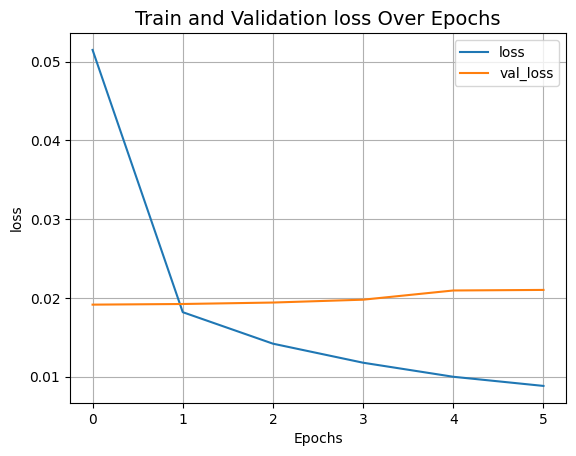

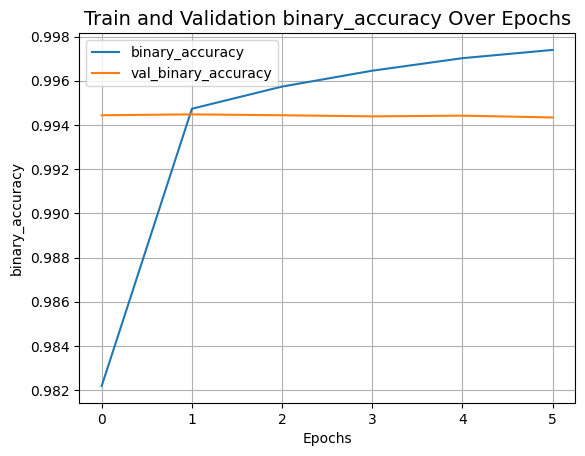

In [127]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [128]:
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.9943 - loss: 0.0192
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - binary_accuracy: 0.9941 - loss: 0.0201
Categorical accuracy on the test set: 99.42%.
Categorical accuracy on the validation set: 99.44%.


In [129]:
model1.save("models/model.h5")

saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)

with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [143]:
import pickle
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization

# Load the model
loaded_model = keras.models.load_model("models/model.h5")

# Load TextVectorization config
with open("models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

# ✅ **Modify the config to avoid tf_idf**
saved_text_vectorizer_config["output_mode"] = "int"  # Or "multi_hot", "count", etc.

# Load the vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

# ✅ **Recreate the TextVectorization layer**
new_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)
new_text_vectorizer.set_vocabulary(loaded_vocab)

print("✅ Successfully loaded TextVectorization layer (without tf_idf weights)!")


✅ Successfully loaded TextVectorization layer (without tf_idf weights)!


In [151]:
def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

def predict_category(summaries, model, vectorizer, label_lookup):
    preprocessed_abstract = vectorizer([summaries])

    predictions = model.predict(preprocessed_abstract)

    predicted_labels = label_lookup(np.round(predictions).astype(int)[0])

    return predicted_labels

recommendation system

In [32]:
arxiv_data.drop(columns=['terms','summaries'], inplace=True)
arxiv_data

,titles
0,Survey on Semantic Stereo Matching / Semantic ...
1,FUTURE-AI: Guiding Principles and Consensus Re...
2,Enforcing Mutual Consistency of Hard Regions f...
3,Parameter Decoupling Strategy for Semi-supervi...
4,Background-Foreground Segmentation for Interio...
...,...
51769,Hierarchically-coupled hidden Markov models fo...
51770,Blinking Molecule Tracking
51771,Towards a Mathematical Foundation of Immunolog...
51772,A Semi-Automatic Graph-Based Approach for Dete...


sentence transformers

In [33]:
from sentence_transformers import SentenceTransformer, util

In [34]:
model = SentenceTransformer('all-MiniLM-l6-v2')

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
sentences = arxiv_data['titles']

In [36]:
embeddings = model.encode(sentences)

In [37]:
embeddings

array([[-3.73324379e-02, -5.35822532e-04, -4.86987457e-02, ...,
         4.00168113e-02, -8.07433017e-03, -1.12721235e-01],
       [-6.75695837e-02, -3.25633064e-02,  2.85482295e-02, ...,
         5.83392121e-02, -2.35455446e-02, -3.87291573e-02],
       [ 3.01970523e-02, -1.08652879e-04,  6.92958385e-02, ...,
         7.74509087e-02, -9.04722884e-02, -3.32056470e-02],
       ...,
       [-1.54421963e-02, -7.96079561e-02,  1.47850504e-02, ...,
         1.22726150e-02,  2.37942804e-02, -4.95932549e-02],
       [ 2.12828666e-02, -7.37964511e-02,  6.02626316e-02, ...,
         1.05841152e-01, -3.17206495e-02, -1.08712167e-01],
       [-2.20820531e-02, -9.52020194e-03, -4.42247987e-02, ...,
         7.34962896e-03, -8.17282591e-03, -8.40815306e-02]], dtype=float32)

In [38]:
c = 0

for sentence, embedding in zip(sentences,embeddings):
    print(sentence)
    print(len(embedding))
    print("")
    if c >= 5:
        break
    c += 1

Survey on Semantic Stereo Matching / Semantic Depth Estimation
384

FUTURE-AI: Guiding Principles and Consensus Recommendations for Trustworthy Artificial Intelligence in Future Medical Imaging
384

Enforcing Mutual Consistency of Hard Regions for Semi-supervised Medical Image Segmentation
384

Parameter Decoupling Strategy for Semi-supervised 3D Left Atrium Segmentation
384

Background-Foreground Segmentation for Interior Sensing in Automotive Industry
384

EdgeFlow: Achieving Practical Interactive Segmentation with Edge-Guided Flow
384



In [47]:
import pickle

with open("models/embeddings.pkl", 'wb') as f:
    pickle.dump(embeddings, f)
    
with open("models/sentences.pkl", 'wb') as f:
    pickle.dump(sentences, f)
    
with open("models/rec_model.pkl", 'wb') as f:
    pickle.dump(model, f)

In [48]:
import pickle 

embeddings = pickle.load(open('models/embeddings.pkl', 'rb'))
sentences = pickle.load(open('models/sentences.pkl', 'rb'))
rec_model = pickle.load(open('models/rec_model.pkl', 'rb'))

In [54]:
import torch

def recommendation(input_paper):
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))

    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)

    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

In [55]:
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
for paper in recommend_papers:
    print(paper)

We recommend to read this paper............
[-8.65552872e-02 -6.00183122e-02 -1.34928469e-02 -1.21878712e-02
 -3.28055359e-02  7.94706345e-02  3.08566238e-03 -7.39433393e-02
 -3.37945111e-02 -4.36708704e-02  1.70474369e-02  2.18700040e-02
 -1.89715195e-02  5.16035631e-02 -1.37362525e-01  2.15410162e-02
 -1.01076514e-02  8.70914608e-02 -8.59382600e-02  4.97858264e-02
 -5.72558828e-02 -1.40037742e-02 -4.67906520e-02 -8.79634451e-03
  2.49912422e-02  7.45883137e-02  2.61065364e-03  5.29479757e-02
 -4.22500372e-02 -1.79642055e-03  7.63382837e-02  1.49575307e-03
 -6.70372695e-03  2.74171680e-02 -1.02491736e-01  8.21857527e-03
 -3.69352698e-02  4.28427942e-02  1.54288765e-03  1.52490626e-03
 -4.24237922e-03 -1.02135278e-02  1.62606034e-02  6.45757169e-02
  1.38741955e-01  1.23773385e-02  1.94158684e-02  1.84004176e-02
  2.22703745e-03  8.54740366e-02 -1.02953605e-01 -1.11039858e-02
 -5.02949134e-02 -1.97472200e-02  2.61166282e-02 -9.29428041e-02
 -1.70518626e-02  1.27816256e-02 -5.10663837e-